In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]
!pip install box2d-py
!pip install gym[Box_2D]
!apt install imagemagick
!pip uninstall -y pygame
!pip install pygame

In [1]:
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env
 
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")  

v_display = Display(visible=0, size=(1400, 900))
v_display.start()

In [2]:
import gym

env = wrap_env(gym.make('CartPole-v1') )
env.reset()
for i in range(100):
    o, reward, done, _ =  env.step(env.action_space.sample())
    if done : break
env.close()
show_video()   

# DQN

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
import random

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
      for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)                
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.mse_loss(q_a, target)# .smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [22]:
s,a,r,s_prime,done_mask = memory.sample(32)
q_out = q(s)   #s=32x4,   q_out=32x2       a=32x1
q_a = q_out.gather(1,a)                   #  action에 해당하는 action 확률가져온다. 
print(q_a.shape)

torch.Size([32, 1])


In [25]:
print(q_target(s_prime).shape)  # 32x2
print(q_target(s_prime).max(1)[0].shape)  # 32x  쵀대값 산출

torch.Size([32, 2])
torch.Size([32])


In [31]:
max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)   # 32x1
target = r + gamma * max_q_prime * done_mask             # r=32x1   , done =32x1  target = 32x1
print(max_q_prime.shape)
print(done_mask.shape)
print(target.shape)

torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


In [40]:
torch.tensor([1,2,3]).unsqueeze(0)   #   1x3
torch.tensor([1,2,3]).unsqueeze(1)   #    3x1
torch.tensor([[1,2,3], [1,2,3]]).unsqueeze(0) #     1x2x3
torch.tensor([[1,2,3], [1,2,3]]).unsqueeze(1) #     2x1x3
torch.tensor([[1,2,3], [1,2,3]]).unsqueeze(2) #     2x3x1

tensor([[[1],
         [2],
         [3]],

        [[1],
         [2],
         [3]]])

In [13]:
env = gym.make('CartPole-v1')
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 100
score = 0.0  
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

epsilon = 0.08

In [14]:
for n_epi in range(100):
        #epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        epsilon = max(0.01, 0.999  * epsilon) #

        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0, s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.5f}".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon))
            score = 0.0
env.close()

torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


In [30]:
torch.save(q.state_dict(), 'cartpole_dqn.pth')

In [ ]:
env = wrap_env(gym.make('CartPole-v1')) 

q_test = Qnet()
q_test.load_state_dict(torch.load('cartpole_dqn.pth'))

# 최대값을 갖는 방향으로 선택
s = env.reset()
done = False
        
score = 0    
while not done: 
    prob = q_test(torch.tensor(s).float()) 
    s_prime, r, done, info = env.step( prob.argmax().item())
    s = s_prime
    score += r
env.close()
print(score)
show_video()  

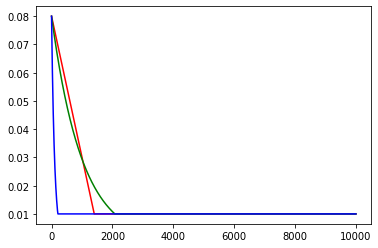

In [22]:
import matplotlib.pyplot as plt

epsilon = max(0.01, 0.08 - 0.01*(n_epi/200))

plt.plot([  max(0.01, 0.08 - 0.01*(i/200))  for i in range(10000)], 'r')
plt.plot([  max(0.01, 0.08*0.999**i    )  for i in range(10000)], 'g')
plt.plot([  max(0.01, 0.08*0.99**i    )  for i in range(10000)], 'b')


